# Overview - analysing propensity to purchase and churn

Planning is underway for marketing campaign to sell accident insurance to their existing customers. 

For a good cost-benefit ratio advertising letters should be sent to customers with a high propensity to buy only
***

## Import and view the data

In [1]:
# Import pandas using the usual alias
import pandas as pd

# Read in the semi-colon separated data from datasets/NEW_BUSINESS_ACCIDENT_10000.csv
propensity_data = pd.read_csv('NEW_BUSINESS_ACCIDENT_10000.csv', sep = ';')

# Print out the first 5 lines of the dataset
print(propensity_data.head(5))

   id  new_business  age  number_of_contracts  property  life  health  \
0   1             0   59                    1         1     0       0   
1   2             0   59                    1         0     1       0   
2   3             0   53                    2         0     1       1   
3   4             0   30                    1         0     0       1   
4   5             0   43                    4         1     0       1   

   premium_customer  premium_household sales_channel new_business_py  \
0            164.00            1976.11         other            none   
1            272.18             272.18    tied_agend            none   
2           1298.28           20160.83    tied_agend            none   
3              5.13               5.13    tied_agend            none   
4            710.61             710.61    tied_agend               p   

   self_employed  gender_male  
0              0            1  
1              0            0  
2              0            0  


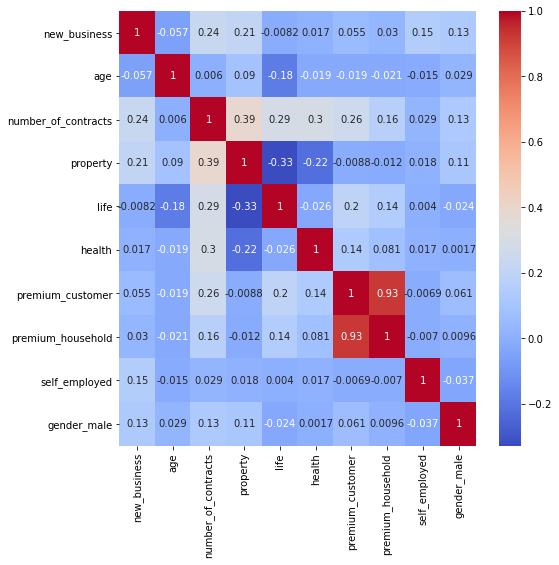

In [2]:
# Import seaborn and matplotlib.pyplot using the usual aliases
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the ID column from the first axis
no_id = propensity_data.drop("id", axis = 1)

# Calculate a correlation matrix of all columns of no_id
corr_matrix = no_id.corr()

# Draw a heatmap of corr_matrix, with annotations, using the 'coolwarm' colormap
plt.figure(figsize = (8, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

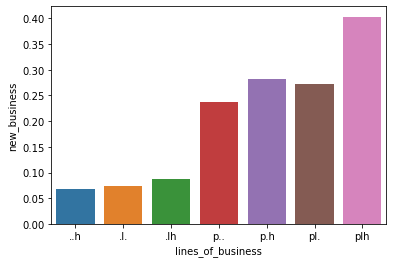

In [3]:
# Import numpy using the usual alias
import numpy as np

# This code returns "p" where the property column is True and "." otherwise
p = np.where(propensity_data["property"], "p", ".") 

# Return "l" where the life column is True and "." otherwise
l = np.where(propensity_data["life"], "l", ".")

# Return "h" where the health column is True and "." otherwise
h = np.where(propensity_data["health"], "h", ".")

# Add the character arrays p, l, and h together
propensity_data["lines_of_business"] = np.char.add(np.char.add(p, l), h)

# For each lines_of_business group, calculate the proportion of new business
prop_new_business_by_lines_of_business = propensity_data.groupby("lines_of_business")["new_business"].mean()

# Reset the index of prop_new_business_by_lines_of_business
prop_new_business_by_lines_of_business_data = prop_new_business_by_lines_of_business.reset_index()

# Draw a bar plot of the proportion of new_business vs. lines_of_business and display it
ax = sns.barplot(data=prop_new_business_by_lines_of_business_data, x="lines_of_business", y="new_business")
plt.show()

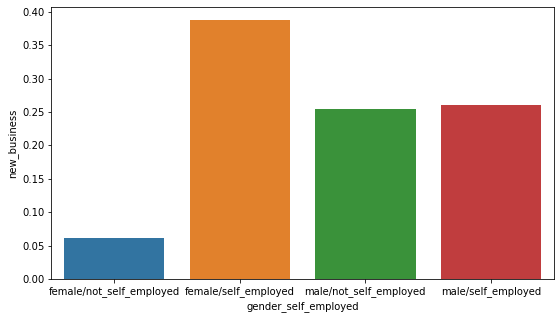

In [4]:
# Return "self_employed" where self_employed column is True, and "not_self_employed" otherwise
propensity_data["self_employment_status"] = np.where(propensity_data["self_employed"], "self_employed", "not_self_employed") 

# Return "male" where gender_male column is True, and "female" otherwise
propensity_data["gender"] = np.where(propensity_data["gender_male"], "male", "female")

# Combine gender and self-employment status into a single feature
propensity_data["gender_self_employed"] = propensity_data["gender"] + "/" + propensity_data["self_employment_status"]

# For each gender-status group, calculate the proportion of new business
prop_new_business_by_gender_self_employment = propensity_data.groupby("gender_self_employed")['new_business'].mean()

# Reset the index of prop_new_business_by_gender_self_employment
prop_new_business_by_gender_self_employment_data = prop_new_business_by_gender_self_employment.reset_index()

# Draw a bar plot of the proportion of new business vs. gender-status group
plt.figure(figsize = (9, 5))
ax = sns.barplot(data=prop_new_business_by_gender_self_employment_data, x="gender_self_employed", y="new_business")
plt.show()

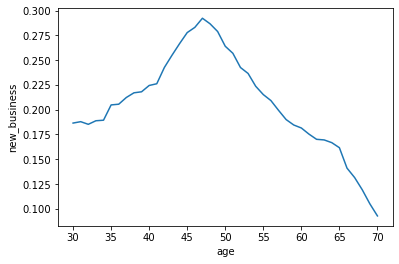

In [5]:
# For each age group, calculate the proportion of new business, then reset the index
prop_new_business_by_age = propensity_data.groupby("age")['new_business'].mean().reset_index()

# Draw a line plot of the proportion of new business vs. age
ax = sns.lineplot(data=prop_new_business_by_age,x='age',y='new_business',ci='None')
plt.show()

## Prepare first model 
***

In [6]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Select the new_business column as the response
response = propensity_data['new_business']

# Log of premium household feature provided
propensity_data["premium_household_log"] = np.log10(
    np.minimum(np.maximum(propensity_data["premium_household"], 1), 50000))

# These features will be included
model1_features = propensity_data[
    ["age", "number_of_contracts", "gender_male", "self_employed", "sales_channel",
     "property", "health", "life", "new_business_py", "premium_household_log"]
]

# Get dummy variables for the features
model1_dummies = pd.get_dummies(model1_features, drop_first=True)

# Split the dataset into training and testing sets with a test size of 30%, 
# using 42 as the random seed and stratified by the response
model1_X_train, model1_X_test, model1_y_train, model1_y_test = train_test_split(model1_dummies,
                                                                                response,
                                                                                test_size=0.3,
                                                                                random_state=42,
                                                                                stratify=response)


In [7]:
# Import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression object using 'newton-cg' as solver
log_reg1 = LogisticRegression(solver='newton-cg')

# Fit the logistic regression model to model1_X_train and model1_y_train 
log_reg1.fit(model1_X_train,model1_y_train)

LogisticRegression(solver='newton-cg')

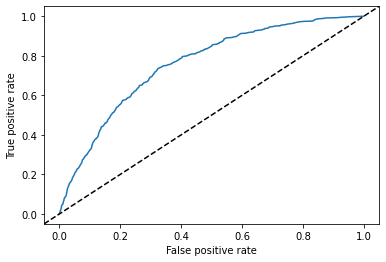

The AUC for Model 1 is 0.76.


In [8]:
# Import roc_curve and roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_curve, roc_auc_score

# Predict the probabilities of buying on the test dataset
model1_prediction_probs = log_reg1.predict_proba(model1_X_test)[:, 1]

# Calculate ROC curve
fpr1, tpr1, thresholds1 = roc_curve(model1_y_test, model1_prediction_probs)

# Draw line plot of true positive rate vs. false positive rate
ax = sns.lineplot(x=fpr1, y=tpr1, ci=None)

# This code adds a dashed line along y = x
ax.axline([0, 0], slope=1, linestyle='--', color='k')

# This code labels the axes and displays the plot
ax.set(xlabel='False positive rate', ylabel='True positive rate')
plt.show()

# Calculate and print the AUC
auc1 = roc_auc_score(model1_y_test, model1_prediction_probs)
print(f"The AUC for Model 1 is {auc1:.2f}.")

## Used dervied variables in a second model
***

In [9]:
# Create an age squared column
propensity_data["age_squared"] = propensity_data["age"] ** 2

# This model also includes age_squared and interactions between gender/self-employment and lines of business
model2_features = propensity_data[
    ["age", "age_squared", "number_of_contracts", "gender_self_employed", 
     "sales_channel", "lines_of_business", "new_business_py", "premium_household_log"]
]

# Get dummy variables for the features
model2_dummies = pd.get_dummies(model2_features, drop_first=True)

# Split the dataset into training and testing sets with a test size of 30%, 
# using 42 as the random seed and stratified by the response
model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(
    model2_dummies,
    response,
    test_size=0.3,
    random_state=42,
    stratify=response
)

# Create a LogisticRegression object using 'newton-cg' as solver
log_reg2 = LogisticRegression(solver='newton-cg')

# Fit the logistic regression model to model2_X_train and model2_y_train 
log_reg2.fit(model2_X_train, model2_y_train)

LogisticRegression(solver='newton-cg')

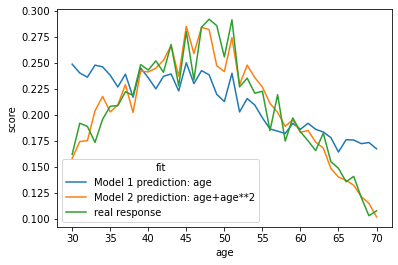

In [10]:
# Predict the probabilities of buying on the training dataset for Model 1
model1_scores_train = log_reg1.predict_proba(model1_X_train)[:, 1]

# Do the same for Model 2
model2_scores_train = log_reg2.predict_proba(model2_X_train)[:, 1]

# Complete the dictionary to fill the DataFrame
real_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 1 training dataset
    'age': model1_X_train['age'], 
    # Get the Model 1 training responses
    'score': model1_y_train, 
    'fit': 'real response'
})

# Complete the dictionary to fill the DataFrame
model1_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 1 training dataset
    'age': model1_X_train['age'], 
    # Get the Model 1 predicted probabilities
    'score': model1_scores_train, 
    'fit': 'Model 1 prediction: age'
})

# Complete the dictionary and convert to a DataFrame
model2_age_scores = pd.DataFrame.from_dict({
    # Get the ages from Model 2 training dataset
    'age': model2_X_train['age'], 
    # Get the Model 2 predicted probabilities
    'score': model2_scores_train, 
    'fit': 'Model 2 prediction: age+age**2'
})

# From real_age_scores append model1_age_scores then append model2_age_scores
age_scores = real_age_scores.append(model1_age_scores).append(model2_age_scores)

# Group `age_scores` by age and fit, select the score column, 
# calculate the mean, and reset the index
modelfit_age = age_scores.groupby(['age', 'fit'])['score'].mean().reset_index()

# Using modelfit_age, draw a line plot of score vs. age colored by fit
ax = sns.lineplot(data=modelfit_age, x='age', y='score', hue='fit', ci=None)
plt.show()

## Compare models
***

AUC1 = 0.758
AUC2 = 0.784


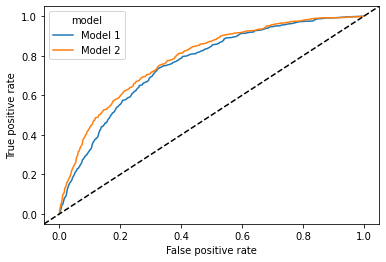

In [11]:
# Predict the probabilities of buying on the Model 2 test dataset
model2_prediction_probs = log_reg2.predict_proba(model2_X_test)[:, 1]

# Calculate the ROC curve using Model 2
fpr2, tpr2, thresholds2 = roc_curve(model2_y_test, model2_prediction_probs)

# This creates a DataFrame of ROC data from Model 1
roc_data1 = pd.DataFrame.from_dict({
    'fpr': fpr1, 
    'tpr': tpr1, 
    'model': 'Model 1'
})
# Create a DataFrame of ROC data from Model 2
roc_data2 = pd.DataFrame.from_dict({
    'fpr':fpr2,
    'tpr':tpr2,
    'model': 'Model 2'
})

# From the Model 1 ROC data, append the Model 2 ROC data
roc_data = roc_data1.append(roc_data2)

# Using roc_data, draw a line plot of true +ve rate vs. false +ve rate colored by model 
ax = sns.lineplot(data = roc_data, x='fpr', y='tpr', ci=None, hue = 'model')

# Add diagonal and labels to the x and y axes
ax.set(xlabel='False positive rate', ylabel='True positive rate')
ax.axline([0, 0], slope=1, linestyle='--', color='black')

# Calculate AUC score of Model 2
auc2 =  roc_auc_score(model2_y_test, model2_prediction_probs)

# Print AUC values for both models
print(f"AUC1 = {auc1:.3f}")
print(f"AUC2 = {auc2:.3f}")

## Examine lift
***

In [12]:
# This code gets 10% of number of observations in the test dataset (300)
n_10_pct = round(len(model1_y_test) * 0.1)

# This code combines actual new business and predicted probabilities using Model 1
model1_score = pd.DataFrame.from_dict({
    'new_business': model1_y_test, 
    'score': model1_prediction_probs
})

# Get the rows of model1_score with the n_10_pct largest scores
model1_top_10_pct = model1_score.nlargest(n=n_10_pct, columns='score')

# Calculate Model 1 10% lift
model1_lift = model1_top_10_pct["new_business"].mean() / model1_y_test.mean()
print(f"Lift 10% Model 1: {model1_lift:.3f}")

# Create a DataFrame combining actual new business and predicted probabilities using Model 2
model2_score = pd.DataFrame.from_dict({
    'new_business': model2_y_test, 
    'score': model2_prediction_probs
})

# Get the rows of model2_score with the n_10_pct largest scores
model2_top_10_pct = model2_score.nlargest(n=n_10_pct, columns='score')

# Calculate Model 2 10% lift
model2_lift = model2_top_10_pct["new_business"].mean() / model2_y_test.mean()
print(f"Lift 10% Model 2: {model2_lift:.3f}")

Lift 10% Model 1: 2.359
Lift 10% Model 2: 2.674
